# Shadowgram analysis
In this notebook, an exploratory analysis of automated algorithms to extract usefull information from Foucault test shadowgrams will be tried out to see what is the best approach.

### Assumptions
 - This notebook assumes that the pictures are obtained from a Foucault (knife edge) test performed on a reflective concave telescope mirror.
 - Both camera and mirror under test are static and maintain the same position across all image captures.
 - The mirror has the same apparent size and position in the camera frame across all images.

# Get image dataset

The dataset is stored in a json file. It contains the list of captured frames and their filenames.

One image frame is picked for analysis.

In [1]:
from pathlib import Path

image_dataset_path = Path.cwd().joinpath("Datasets", "(165) 13_06_2019", "1")

In [2]:
import json

image_database_file_path = image_dataset_path.joinpath("mirror_measurements_database.json")

with image_database_file_path.open(mode="r") as data_base_file:
    data_base = json.load(data_base_file)
    data_base_file.close()

telescope_mirror_diameter = data_base['diameter']
telescope_mirror_measurements = sorted(data_base['measurements'], key=lambda meas: meas['optical_axis_offset']) # list of dictionaries

print('List of available images:')
for measurement in telescope_mirror_measurements:
    print(measurement['foucaultgram'])

List of available images:
Image_0.0.png
Image_0.1.png
Image_0.2.png
Image_0.3.png
Image_0.4.png
Image_0.5.png
Image_0.6.png
Image_0.7.png
Image_0.8.png
Image_0.9.png
Image_1.0.png
Image_1.1.png
Image_1.2.png
Image_1.3.png
Image_1.4.png
Image_1.5.png
Image_1.6.png
Image_1.7.png
Image_1.8.png
Image_1.9.png
Image_2.0.png
Image_2.1.png
Image_2.2.png


# Import a shadowgram image from the dataset
First, pick a captured image from a Foucault test on a concave telescope mirror and show it.

In [3]:
test_image_file_path = image_dataset_path.joinpath("Image_1.0.png")

In [4]:
import cv2

# Load our input image
capture = cv2.imread(str(test_image_file_path))

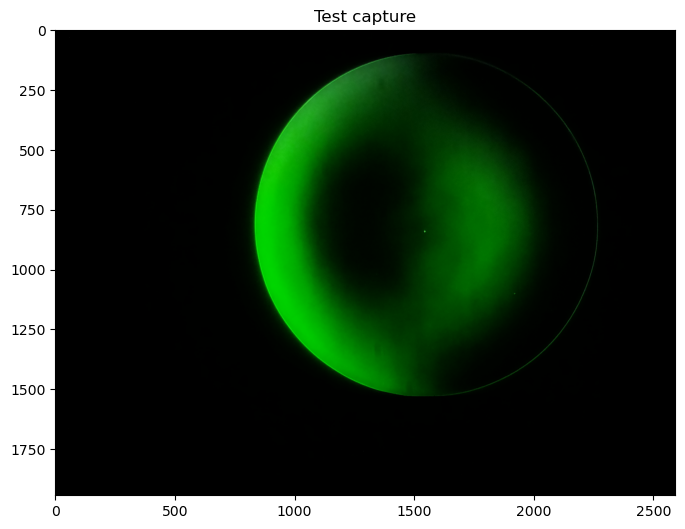

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test capture')

# call imshow() using plt object
plt.imshow(capture)
  
# display that image
plt.show()

# Convert captured image to grayscale

This step is required for the algorithms used next.

In [6]:
# convert color image into grayscale image
capture_gray = cv2.cvtColor(capture, cv2.COLOR_RGB2GRAY)

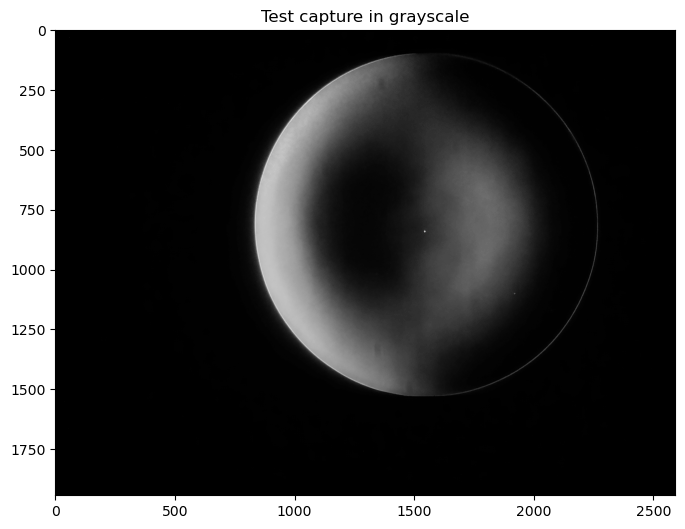

In [7]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test capture in grayscale')

# call imshow() using plt object
plt.imshow(capture_gray, cmap='gray')
  
# display that image
plt.show()

# Perform edge detection

Required to know the mirror boundaries and to be used as the basis for circle and ellipse fitting.

In [8]:
capture_gray_blur = capture_gray
#capture_gray_blur = cv2.blur(capture_gray, (3,3))
#capture_gray_blur = cv2.bilateralFilter(capture_gray, 6, 6 * 2, 6 / 2)

canny_threshold_1 = 10
canny_threshold_2 = 80
capture_canny = cv2.Canny(capture_gray_blur, canny_threshold_1, canny_threshold_2, L2gradient=True)

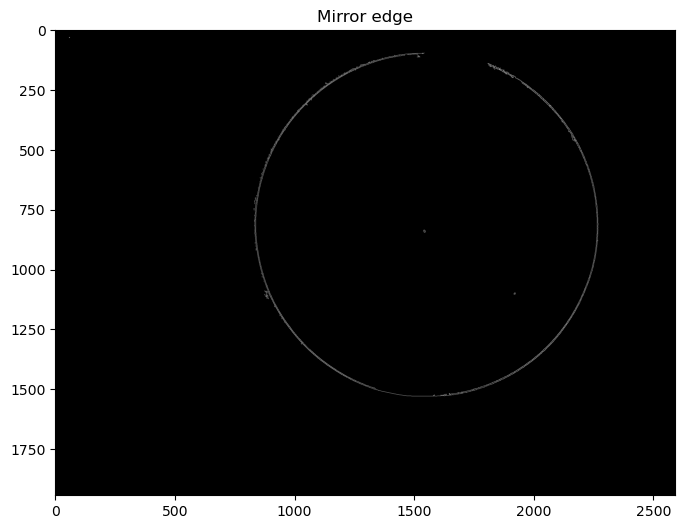

In [9]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Mirror edge')

# call imshow() using plt object
plt.imshow(capture_canny, cmap='gray')
  
# display that image
plt.show()

# Fit a circle to the (expected round) edge

Locate the mirror round edge on the image and get a first approximation of its shape.

In [10]:
import numpy as np

circles = cv2.HoughCircles(capture_gray, cv2.HOUGH_GRADIENT,
                           1, 800, param1=canny_threshold_2, param2=20, minRadius=400, maxRadius=1500)

if np.any(circles) != True:
  raise Exception("HoughCircles found no circles.")

if circles.size != 3:
    raise Exception("HoughCircles found more than one circle.")

circles = np.uint16(np.around(circles))
circles = circles[0, 0]

# draw fitted circle and inside and outside circles
circle_radius_tolerance = 30
line_thickness = 1
color_circle = (255, 0, 0)
circle_center = (circles[0], circles[1])
circle_radius = circles[2]
capture_circle = np.copy(capture)
capture_circle = cv2.circle(capture_circle, circle_center, circle_radius,
                            color_circle, line_thickness, cv2.LINE_AA)
capture_circle = cv2.circle(capture_circle, circle_center, circle_radius-circle_radius_tolerance,
                            color_circle, line_thickness, cv2.LINE_AA)
capture_circle = cv2.circle(capture_circle, circle_center, circle_radius+circle_radius_tolerance,
                            color_circle, line_thickness, cv2.LINE_AA)

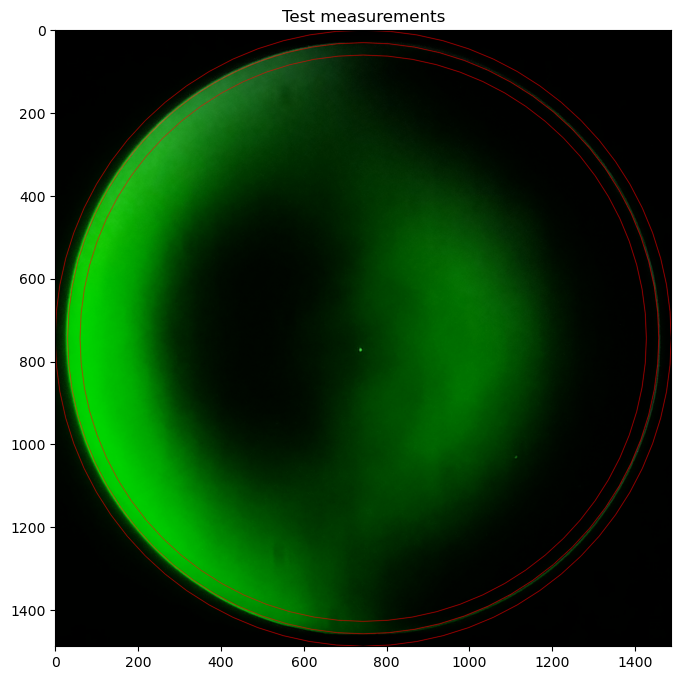

In [11]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_circle[circle_center[1]-circle_radius-circle_radius_tolerance:circle_center[1]+circle_radius+circle_radius_tolerance,
           circle_center[0]-circle_radius-circle_radius_tolerance:circle_center[0]+circle_radius+circle_radius_tolerance])
  
# display that image
plt.show()

# Crop image to the area of interest

Remove unwanted image area.

In [12]:
capture = capture[circle_center[1]-circle_radius-circle_radius_tolerance:circle_center[1]+circle_radius+circle_radius_tolerance,
circle_center[0]-circle_radius-circle_radius_tolerance:circle_center[0]+circle_radius+circle_radius_tolerance]

capture_gray = capture_gray[circle_center[1]-circle_radius-circle_radius_tolerance:circle_center[1]+circle_radius+circle_radius_tolerance,
circle_center[0]-circle_radius-circle_radius_tolerance:circle_center[0]+circle_radius+circle_radius_tolerance]

capture_gray_blur = capture_gray_blur[circle_center[1]-circle_radius-circle_radius_tolerance:circle_center[1]+circle_radius+circle_radius_tolerance,
circle_center[0]-circle_radius-circle_radius_tolerance:circle_center[0]+circle_radius+circle_radius_tolerance]

capture_canny = capture_canny[circle_center[1]-circle_radius-circle_radius_tolerance:circle_center[1]+circle_radius+circle_radius_tolerance,
circle_center[0]-circle_radius-circle_radius_tolerance:circle_center[0]+circle_radius+circle_radius_tolerance]

# update fitted circle center to cropped area
circle_center = (circle_radius+circle_radius_tolerance, circle_radius+circle_radius_tolerance)

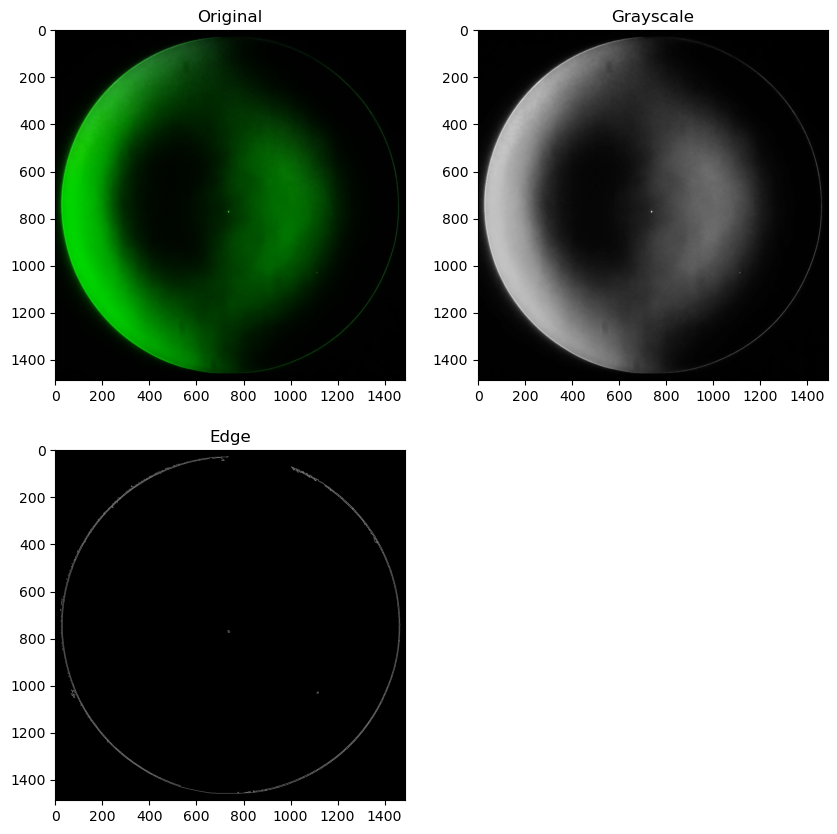

In [13]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 10]
#plt.rcParams['figure.dpi'] = 120

plt.subplot(2, 2, 1)
plt.title('Original')
plt.imshow(capture)

plt.subplot(2, 2, 2)
plt.title('Grayscale')
plt.imshow(capture_gray, cmap='gray')

plt.subplot(2, 2, 3)
plt.title('Edge')
plt.imshow(capture_canny, cmap='gray')

# display that image
plt.show()

# Fit an ellipse to the (expected round) edge

With the mirror now located and the image cropped to show it, fit an ellipse to the mirror edge.

The ellipse is a better approximation than a circle to the mirror's edge due to any camera/mirror misalignments.

In [14]:
capture_canny_points = cv2.findNonZero(capture_canny)

#ellipse = cv2.fitEllipse(capture_canny_points)
#ellipse = cv2.fitEllipseAMS(capture_canny_points)
ellipse = cv2.fitEllipseDirect(capture_canny_points)

line_thickness = 1
color_ellipse = (255, 0, 0)
capture_ellipse = np.copy(capture)
capture_ellipse = cv2.ellipse(capture_ellipse, ellipse, color_ellipse, line_thickness, cv2.LINE_AA)

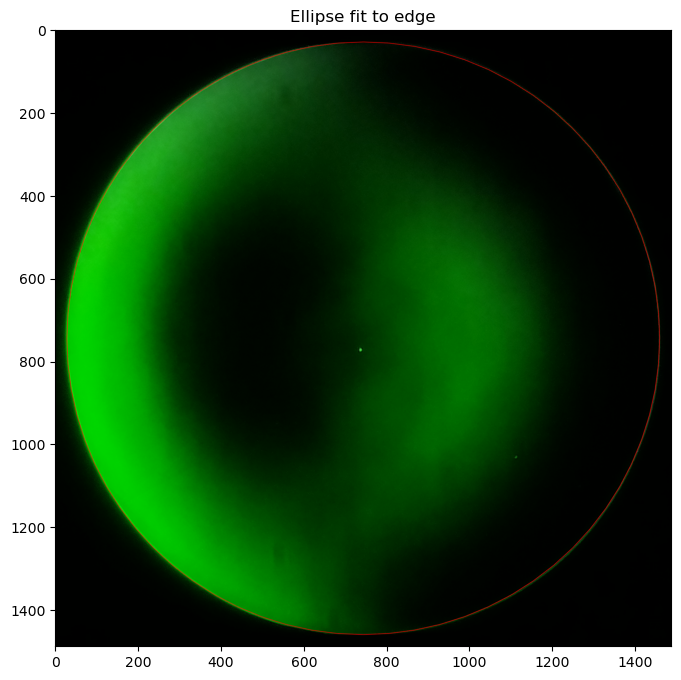

In [15]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Ellipse fit to edge')

# call imshow() using plt object
plt.imshow(capture_ellipse)
  
# display that image
plt.show()

# Create shadowgram color histogram on inside pixels of the mirror area only

With the best fit ellipse, use it to select only the pixels belonging to the mirror area and determine the color histogram on them.

In [16]:
capture_gray_hist_mask = np.full_like(capture_gray, 0)
capture_gray_hist_mask = cv2.ellipse(capture_gray_hist_mask, ellipse, color_ellipse, -1, cv2.LINE_AA)

capture_gray_hist = cv2.calcHist([capture_gray], [0], capture_gray_hist_mask, [256], [0,256])

Based on the color histogram, determine the median color displayed on the mirror.

This will be used as the boundary between the light and shadow areas of the mirror. It is based on the (to be proven) assumption that on a mirror without major defects, the shadow and light areas have the same area and thus the color that sits in the middle (median) represents the null zone.

In [17]:
capture_gray_hist_cdf = np.cumsum(capture_gray_hist)
median_cdf = np.around(capture_gray_hist_cdf[-1]/2)
capture_gray_median_color = (np.abs(capture_gray_hist_cdf - median_cdf)).argmin()

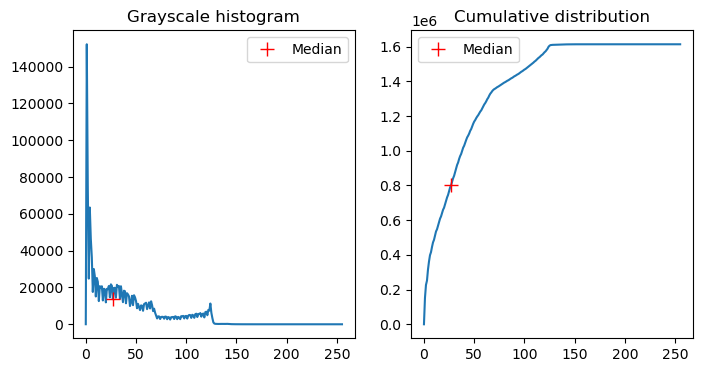

In [18]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 4]
#plt.rcParams['figure.dpi'] = 120

plt.subplot(1, 2, 1)
plt.title('Grayscale histogram')
plt.plot(capture_gray_hist)
plt.plot(capture_gray_median_color, capture_gray_hist[capture_gray_median_color],
         "r+", markersize=10, label="Median")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Cumulative distribution')
plt.plot(capture_gray_hist_cdf)
plt.plot(capture_gray_median_color, capture_gray_hist_cdf[capture_gray_median_color],
         "r+", markersize=10, label="Median")
plt.legend()

# display plots
plt.show()

# Segment shadow and light areas on the shadowgram

In [19]:
threshold = capture_gray_median_color
_, capture_thresh = cv2.threshold(capture_gray_blur, threshold, 255, cv2.THRESH_BINARY)

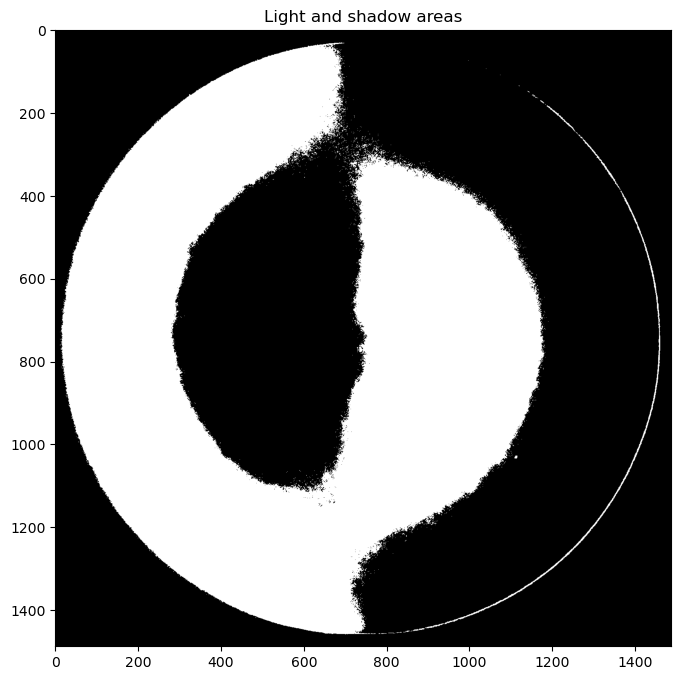

In [20]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Light and shadow areas')

# call imshow() using plt object
plt.imshow(capture_thresh, cmap='gray')

# display that image
plt.show()

# (Delete?) Determine shadowgram zone transitions across horizontal diameter

In [21]:
sample_height = 30
capture_sample = capture_thresh[circle_center[1]-sample_height:circle_center[1]+sample_height, :]

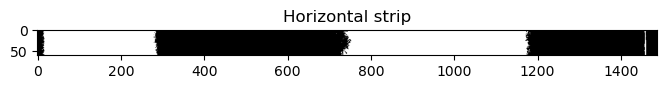

In [22]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Horizontal strip')

# call imshow() using plt object
plt.imshow(capture_sample, cmap='gray')

# display that image
plt.show()

In [23]:
from scipy.signal import find_peaks

capture_sample_averaged = np.mean(capture_sample, axis=0)
capture_sample_transitions = np.absolute(np.gradient(capture_sample_averaged))

capture_sample_transition_peaks, _ = find_peaks(capture_sample_transitions, height=25, distance=50)

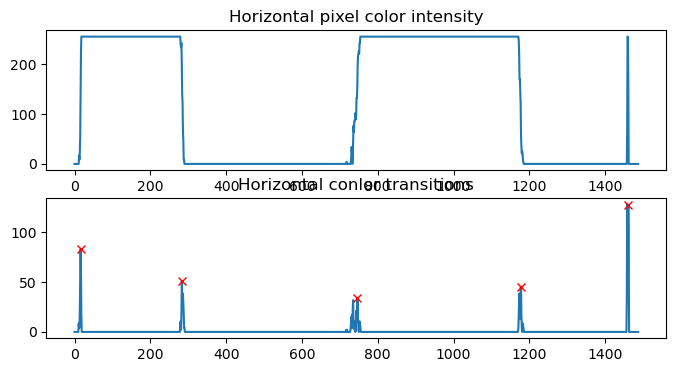

In [24]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 4]
#plt.rcParams['figure.dpi'] = 120

plt.subplot(2, 1, 1)
plt.title('Horizontal pixel color intensity')
plt.plot(capture_sample_averaged)

plt.subplot(2, 1, 2)
plt.title('Horizontal conlor transitions')
plt.plot(capture_sample_transitions)
plt.plot(capture_sample_transition_peaks, capture_sample_transitions[capture_sample_transition_peaks], "rx")

# display plots
plt.show()

# (Delete?) Determine shadowgram null zone diameter - first approximation 

In [25]:
if np.all(np.diff(capture_sample_transition_peaks) >= 0) != True or capture_sample_transition_peaks.size != 5:
    raise Exception("Shadow transitions are not sequencial and the correct number.")

capture_diameter_marker = np.copy(capture)

center = (circle_center[0]+circle_radius + circle_center[0]-circle_radius)/2
diameter_full = capture_sample_transition_peaks[4] - capture_sample_transition_peaks[0] # in pixels
radius_full = diameter_full/2 # in pixels

radius_zone_l = ((center - capture_sample_transition_peaks[1])/radius_full)*(telescope_mirror_diameter/2)
radius_zone_r = ((capture_sample_transition_peaks[3] - center)/radius_full)*(telescope_mirror_diameter/2)

diameter_zone_l = radius_zone_l*2
diameter_zone_r = radius_zone_r*2

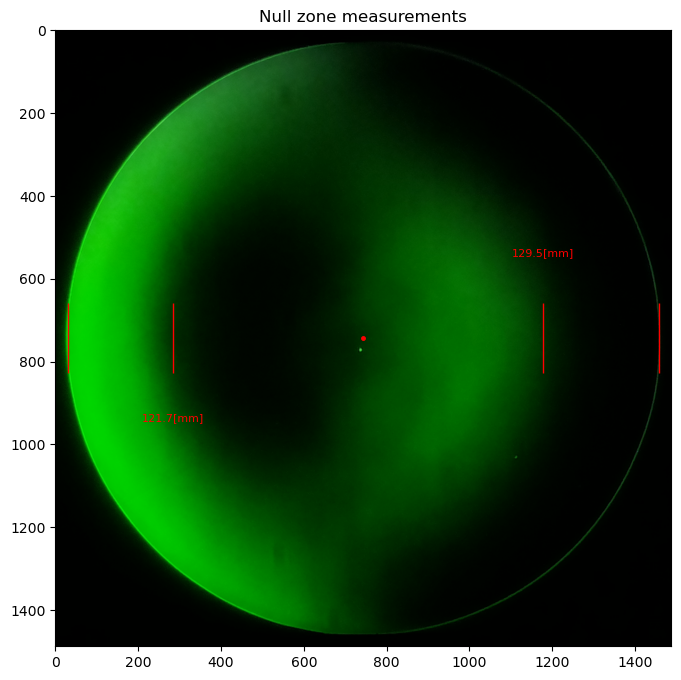

In [26]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Null zone measurements')

# call imshow() using plt object
plt.imshow(capture_diameter_marker)
plt.plot(circle_center[0]-circle_radius, circle_center[1], "r|", markersize=50)
plt.plot(circle_center[0]+circle_radius, circle_center[1], "r|", markersize=50)
plt.plot(capture_sample_transition_peaks[1], circle_center[1], "r|", markersize=50)
plt.plot(capture_sample_transition_peaks[3], circle_center[1], "r|", markersize=50)
plt.plot(circle_center[0], circle_center[1], "r.", markersize=5)
plt.text(capture_sample_transition_peaks[1], circle_center[1]+200, f'{diameter_zone_r:.1f}[mm]',
         fontsize=8, color='r', horizontalalignment='center')
plt.text(capture_sample_transition_peaks[3], circle_center[1]-200, f'{diameter_zone_l:.1f}[mm]',
         fontsize=8, color='r', horizontalalignment='center')

# display that image
plt.show()

# Determine shadowgram null zone diameter - second approximation

In [27]:
thresh_null_canny_threshold_1 = 10
thresh_null_canny_threshold_2 = 80
capture_thresh_canny = cv2.Canny(capture_thresh, thresh_null_canny_threshold_1, thresh_null_canny_threshold_2, L2gradient=True)

In [28]:
# first mask area around null zone
line_thickness = 100
thresh_null_zone_mask = np.full_like(capture_thresh, 0)
thresh_null_zone_mask = cv2.circle(thresh_null_zone_mask, circle_center, circle_center[0]-capture_sample_transition_peaks[1],
                                   255, line_thickness, cv2.LINE_AA)

thresh_circles_masked = cv2.bitwise_and(capture_thresh_canny, thresh_null_zone_mask)

thresh_null_zone_mask = np.full_like(capture_thresh, 255)
pt1 = [circle_center[0], 0]
pt2 = [circle_center[0], circle_center[0]+circle_radius+circle_radius_tolerance]
thresh_null_zone_mask = cv2.line(thresh_null_zone_mask, pt1, pt2, 0, line_thickness)

thresh_circles_masked = cv2.bitwise_and(thresh_circles_masked, thresh_null_zone_mask)

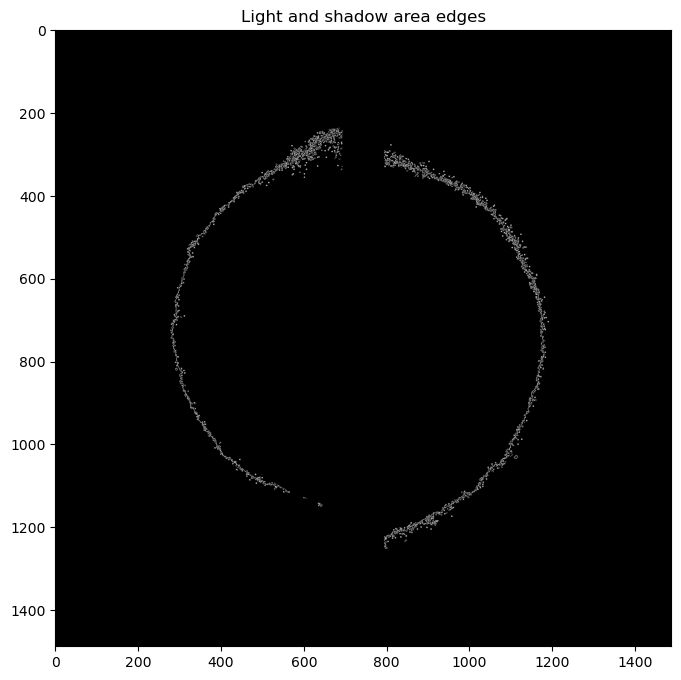

In [29]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Light and shadow area edges')

# call imshow() using plt object
plt.imshow(thresh_circles_masked, cmap='gray')

# display that image
plt.show()

In [30]:
thresh_circles = cv2.HoughCircles(thresh_circles_masked, cv2.HOUGH_GRADIENT,
                                  1, 800, param1=canny_threshold_2, param2=20, minRadius=200, maxRadius=1500)

print(thresh_circles)

[[[ 746.5  754.5  433.2]
  [ 332.5   54.5  353.9]
  [1168.5   43.5  392.8]
  [1408.5 1392.5  488.5]]]


In [31]:
thresh_circles = np.uint16(np.around(thresh_circles))
thresh_circles = thresh_circles[0, 0]

# draw fitted circle and inside and outside circles
line_thickness = 10
color_circle = (255, 0, 0)
thresh_circle_center = (thresh_circles[0], thresh_circles[1])
thresh_circle_radius = thresh_circles[2]
#capture_thresh_circle = np.copy(capture_thresh)
capture_thresh_circle = cv2.circle(capture_thresh, thresh_circle_center, thresh_circle_radius,
                                   color_circle, line_thickness, cv2.LINE_AA)

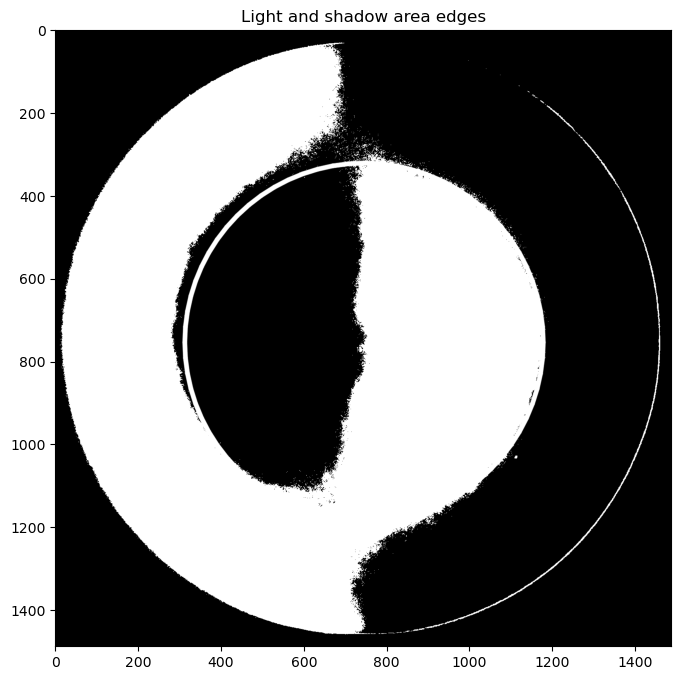

In [32]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Light and shadow area edges')

# call imshow() using plt object
plt.imshow(capture_thresh_circle, cmap='gray')

# display that image
plt.show()